### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [16]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from irrep_bounds import *
from bound_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def r2(model1, model2):
    if not isinstance(model1, MLP4):
        model1 = model1.fold_linear()
    if not isinstance(model2, MLP4):
        model2 = model2.fold_linear()
    num = {name1: ((p1 - p2).norm()**2).item() for (name1, p1), (name2, p2) in zip(model1.named_parameters(), model2.named_parameters())}
    denom = {name: (p.norm()**2).item() for name, p in model1.named_parameters()}
    return {name: 1 - num[name]/denom[name] for name in num}

In [4]:

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
# MODEL_DIR = '2024-09-22_22-12-21_gapF11_MLP2_256_wd1e-4_ubias'
# MODEL_DIR = '2024-09-23_01-06-18_A5x2_MLP2_128_wd1e-4_ubias'
# MODEL_DIR = '2024-09-23_02-50-16_sg96_227_MLP2_128_wd1e-4_ubias'

disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir,) #sel='final')
models = models[-1]  # get last checkpoint
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [12]:
r2s = []
norms = []
avars = []
for instance in tqdm(range(len(models))):
    model = models[instance]
    model = model.fold_linear()
    irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)
    vecs, avar = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=False)
    avars.append(avar)
    unif_vecs = get_unif_vecs(irreps, vecs)
    ideal, _ = get_idealized_model(model, irreps, irrep_idx_dict, unif_vecs)
    r2s.append(r2(model, ideal))
    norms.append({name: p.norm().item() for name, p in model.named_parameters()})

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: get_unif_vecs() missing 1 required positional argument: 'vecs'

In [17]:
# lin_irrep_times = []
# lin_irrep_accs = []
irrep_times = []
irrep_accs = []
naive_times = []
naive_accs = []
avar_bad = []
irrep_bad = []
for instance in tqdm(range(len(models))):
    model = models[instance]
    naive_acc, naive_time = naive_acc_bound(model, group)
    naive_times.append(naive_time)
    naive_accs.append(naive_acc)
    
    irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)
    vecs, avar = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=False)
    if avar > 1e-5:
        avar_bad.append(instance)
        print('avar bad!')
    if '4d-1' not in vecs.keys():
        irrep_bad.append(instance)
        print('irrep bad!')
    # irrep_acc_lin, irrep_time_lin = irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs, linear=True)
    irrep_acc, irrep_time = irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs, linear=False)
    # lin_irrep_accs.append(irrep_acc_lin)
    # lin_irrep_times.append(irrep_time_lin)
    irrep_accs.append(irrep_acc)
    irrep_times.append(irrep_time)
    print('brute', naive_acc, naive_time)
    # print('lin', irrep_acc_lin, irrep_time_lin)
    print('quad', irrep_acc, irrep_time)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/wilson/Finite-groups/src/irrep_bounds.py:455: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # check irreps
  1%|          | 1/100 [00:03<05:56,  3.60s/it]

brute 1.0 2.501187324523926
quad 1.0 0.9329941272735596


  2%|▏         | 2/100 [00:07<05:47,  3.54s/it]

brute 1.0 2.431025505065918
quad 0.0 0.9183852672576904


  3%|▎         | 3/100 [00:10<05:47,  3.58s/it]

brute 1.0 2.490644693374634
quad 1.0 0.9302692413330078


  4%|▍         | 4/100 [00:14<05:41,  3.56s/it]

brute 1.0 2.4739580154418945
quad 1.0 0.8886175155639648


  4%|▍         | 4/100 [01:11<28:30, 17.81s/it]


KeyboardInterrupt: 

In [49]:
bad = np.array(avars) > 1e-5

In [62]:
t.tensor(bad).nonzero()

tensor([[ 4],
        [13],
        [15],
        [19],
        [23],
        [25],
        [31],
        [35],
        [38],
        [44],
        [45],
        [47],
        [52],
        [62],
        [63],
        [65],
        [69],
        [73],
        [76],
        [80],
        [91],
        [94],
        [95],
        [98]])

In [61]:
(t.tensor(quad_irrep_accs) < 0.5).nonzero()

tensor([[ 4],
        [ 5],
        [11],
        [13],
        [14],
        [15],
        [19],
        [21],
        [22],
        [23],
        [25],
        [27],
        [28],
        [29],
        [31],
        [33],
        [35],
        [36],
        [38],
        [44],
        [45],
        [47],
        [49],
        [50],
        [52],
        [54],
        [55],
        [56],
        [62],
        [63],
        [64],
        [65],
        [69],
        [71],
        [72],
        [73],
        [75],
        [76],
        [77],
        [79],
        [80],
        [89],
        [91],
        [92],
        [94],
        [95],
        [97],
        [98]])

/tmp/ipykernel_27539/4155864704.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


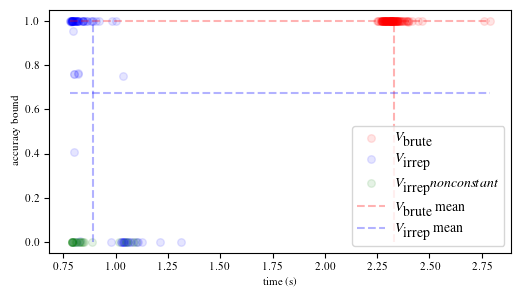

In [59]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

# width as measured in inkscape
width = 5.5
height = 3

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

good_irrep_times = np.array(quad_irrep_times)[~bad]
bad_irrep_times = np.array(quad_irrep_times)[bad]
good_irrep_accs = np.array(quad_irrep_accs)[~bad]
bad_irrep_accs = np.array(quad_irrep_accs)[bad]


ax.scatter(naive_times, naive_accs, label='$V_{\\textrm{brute}}$', alpha=0.1, color='red', s=30)
# plt.scatter(lin_irrep_times, lin_irrep_accs, label='linear', alpha=0.3, color='green', s=20)
ax.scatter(good_irrep_times, good_irrep_accs, label='$V_{\\textrm{irrep}}$', alpha=0.1, color='blue', s=30)
ax.scatter(bad_irrep_times, bad_irrep_accs, label='$V_{\\textrm{irrep}} nonconstant$', alpha=0.1, color='green', s=30)
#ax.errorbar([np.mean(naive_times)], [np.mean(naive_accs)], xerr=np.std(naive_times), yerr=np.std(naive_accs), label='$V_{\\textrm{brute}}$ mean/std', color='red', marker='o', capsize=3)#, s=40)
# plt.errorbar([np.mean(lin_irrep_times)], [np.mean(lin_irrep_accs)], xerr=np.std(lin_irrep_times), yerr=np.std(lin_irrep_accs), label='linear mean/std', color='green', marker='o')#, s=40)
#ax.errorbar([np.mean(quad_irrep_times)], [np.mean(quad_irrep_accs)], xerr=np.std(quad_irrep_times), yerr=np.std(quad_irrep_accs), label='$V_{\\textrm{irrep}}$ mean/std', color='blue', marker='o', capsize=3)#, s=40)
ax.hlines(np.mean(naive_accs), min(good_irrep_times), max(naive_times), color='red', linestyle='--', label='$V_{\\textrm{brute}}$ mean', alpha=0.3)
ax.vlines(np.mean(naive_times), 0, 1, color='red', linestyle='--', alpha=0.3) #label='$V_{\\textrm{brute}}$ mean time', alpha=0.3)
ax.hlines(np.mean(good_irrep_accs), min(good_irrep_times), max(naive_times), color='blue', linestyle='--', label='$V_{\\textrm{irrep}}$ mean', alpha=0.3)
ax.vlines(np.mean(good_irrep_times), 0, 1, color='blue', linestyle='--', alpha=0.3) #label='$V_{\\textrm{irrep}}$ mean time', alpha=0.3)
ax.set_xlabel('time (s)')
ax.set_ylabel('accuracy bound')
# ax.set_title('Accuracy bounds vs. time (S5, 100 model instances)')
ax.legend()
# fig.savefig('../figs/acc_bound_S5.pdf')
fig.set_size_inches(width, height)
fig.show()

In [13]:
np.mean(irrep_accs)

np.float64(0.85)

In [72]:
t.save((naive_times, naive_accs, quad_irrep_times, quad_irrep_accs), '../data/acc_bound_S5.pt')

In [4]:
naive_times, naive_accs, quad_irrep_times, quad_irrep_accs = t.load('../data/acc_bound.pt')

/tmp/ipykernel_27539/3762835154.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  naive_times, naive_accs, quad_irrep_times, quad_irrep_accs = t.load('../data/acc_bound.pt

In [74]:
np.mean(naive_accs), np.mean(quad_irrep_accs)

(np.float64(0.9999625000000001), np.float64(0.5115673605585471))

In [19]:
loss_dict = test_loss(models.to(device), data)

In [20]:
# instance = loss_dict['G0_acc'].argmax().item()
# instance = loss_dict['G0_loss'].argmin().item()
# instance = (loss_dict['G0_acc'] > 0.999).nonzero()[11]
instance = 5
print(loss_dict[f'G0_loss'][instance], loss_dict[f'G0_acc'][instance], instance)
model = models[instance].to(device)

tensor(0.0520) tensor(1.) 5


In [21]:
norm12 = lambda A: A.norm(dim=0).max()  # max 2-norm along group dimension
# note: norm2inf in the correct one to use for both embed and unembed. bc of how the transposes work
norm2inf = lambda A: A.norm(dim=1).max()  # max 2-norm along neuron dimension
norm22 = lambda A: t.linalg.matrix_norm(A, ord=2)

ln, rn, un = model.get_neurons(True)

In [22]:
irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)

In [65]:
vecs, _ = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=True, verbose=True)

1d-0
1-r2 90th percentile 0.0
a variance: 0.0
b variance: 1.0
c variance: 1.0
d variance: 0.0
a vs d tensor(0.)
tensor(0.)
b_mean tensor([[1.]])
c_mean tensor([[-1.]])

4d-0
5d-0
1-r2 90th percentile 0.04404069483280182
a variance: 2.581611227014946e-07
b variance: 0.9984052777290344
c variance: 0.9999983310699463
d variance: 4.323157440921932e-07
a vs d tensor(1.3445e-06)
tensor(0.5760)
tensor(0.5757)
tensor(0.0596)
b_mean tensor([[-0.3986,  0.5766, -0.0890, -0.3986, -0.5766],
        [ 0.4630, -1.0975, -1.1936,  1.1763,  2.0373],
        [-0.0949, -0.5717, -0.3634, -0.5803, -0.4167]])
c_mean tensor([[ 0.3998, -0.5784,  0.0893,  0.3998,  0.5784],
        [-0.0245,  1.3424, -0.6728,  0.2539, -1.0504],
        [ 0.0893,  0.5786,  0.4000,  0.5786,  0.4000]])

6d-0
5d-1
1-r2 90th percentile 0.04098091647028923
a variance: 7.489208655897528e-06
b variance: 0.9977744221687317
c variance: 0.9988373517990112
d variance: 2.0240629510226427e-06
a vs d tensor(1.2407e-05)
tensor(0.4951)
tensor(0.

In [67]:
vecs.keys()

dict_keys(['1d-0', '5d-0', '5d-1'])

In [66]:
unif_vecs = get_unif_vecs(group, irreps, vecs)

5d-0 zeroed 10 46 stab 20
tensor([3.3033, 3.4059, 4.0717, 3.2057, 3.1665, 3.1208, 3.7304, 3.5897, 3.5835,
        3.7383, 3.3399, 2.7590, 4.8199, 3.5795, 3.2963, 3.6384, 4.0813, 3.6729,
        4.8236, 3.2766, 2.9455, 3.2394, 3.5929, 3.1394, 3.0753, 4.0306, 4.0342,
        2.7584, 3.5288, 2.9950, 3.6194, 2.9395, 3.6463, 3.2474, 2.7185, 3.5855,
        3.1799, 3.7733, 3.9282, 3.6768, 3.6159, 3.7440, 3.1818, 2.7876, 3.8423,
        3.3599])
5d-0 zeroed 14354 46 stab 1
tensor([3.3033, 3.4059, 4.0717, 3.2057, 3.1665, 3.1208, 3.7304, 3.5897, 3.5835,
        3.7383, 3.3399, 2.7590, 4.8199, 3.5795, 3.2963, 3.6384, 4.0813, 3.6729,
        4.8236, 3.2766, 2.9455, 3.2394, 3.5929, 3.1394, 3.0753, 4.0306, 4.0342,
        2.7584, 3.5288, 2.9950, 3.6194, 2.9395, 3.6463, 3.2474, 2.7185, 3.5855,
        3.1799, 3.7733, 3.9282, 3.6768, 3.6159, 3.7440, 3.1818, 2.7876, 3.8423,
        3.3599])
5d-0 zeroed 4 46 stab 20
tensor([3.3033, 3.4059, 4.0717, 3.2057, 3.1665, 3.1208, 3.7304, 3.5897, 3.5835,
       

In [38]:
ideal, _ = get_idealized_model(model, irreps, irrep_idx_dict, unif_vecs)

In [39]:
ln, rn, un = model.get_neurons(True)
ubias = model.unembed_bias.detach().T
ln_ideal, rn_ideal, un_ideal = ideal.get_neurons(True)
ubias_ideal = ideal.unembed_bias.detach().T

In [40]:
test_loss(ideal, data), test_loss(model, data)

({'G0_loss': tensor([4.2472]), 'G0_acc': tensor([0.0167])},
 {'G0_loss': tensor([0.0520]), 'G0_acc': tensor([1.])})

In [41]:
margins = []
for i, j in product(range(len(group)), repeat=2):
    out = ideal(t.tensor([[i, j]])).flatten()
    top2 = out.topk(k=2).values
    margins.append((top2[0] - top2[1]).item())

In [111]:
np.std(margins)

np.float64(4.952091884974561e-06)

In [112]:
dists = model_dist_xy(model, ideal, 'inf')

In [113]:
import plotly.graph_objects as go
trace1 = go.Histogram(x=dists, opacity=0.5, name='logit dist')
trace2 = go.Histogram(x=margins, opacity=0.5, name='margin')
layout = go.Layout(
    # yaxis_type="log",
    width=800,
    height=500,
    title=dict(
        text='Margin vs logit distance bounds, V_irrep, S5',
        font=dict(size=24)  # Increase title font size
    ),
    xaxis=dict(
        title='Value',
        titlefont=dict(size=24),  # Increase x-axis title font size
        tickfont=dict(size=24)  # Increase x-axis tick label font size
    ),
    yaxis=dict(
        title='Count',
        titlefont=dict(size=24),  # Increase y-axis title font size
        tickfont=dict(size=24),  # Increase y-axis tick label font size
        range=[0, 2500],
    ),
    legend=dict(font=dict(size=24)),
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

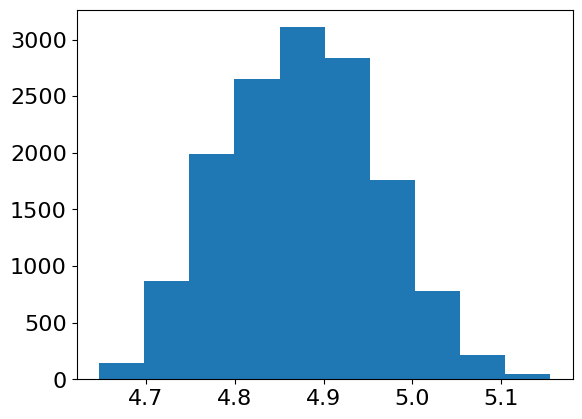

In [41]:
plt.hist(model_dist_xy(model, ideal, 'inf'))
plt.show()

(array([  15.,  184.,  904., 2742., 2003., 4477., 2888.,  894.,  247.,
          46.]),
 array([5.8213625 , 5.82136421, 5.82136593, 5.82136765, 5.82136936,
        5.82137108, 5.8213728 , 5.82137451, 5.82137623, 5.82137794,
        5.82137966]),
 <BarContainer object of 10 artists>)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

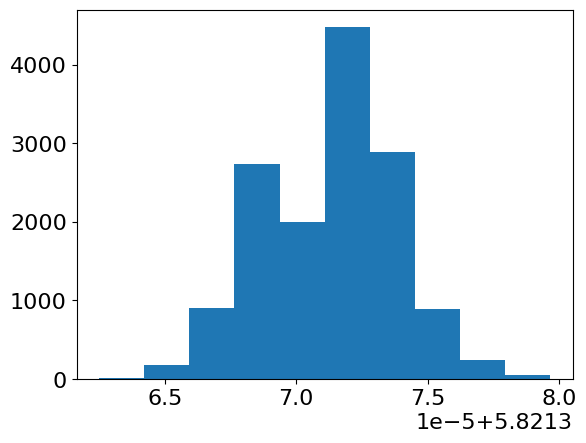

In [40]:
margins = []
for i, j in product(range(len(group)), repeat=2):
    out = ideal(t.tensor([[i, j]])).flatten()
    top2 = out.topk(k=2).values
    margins.append((top2[0] - top2[1]).item())
plt.hist(margins)

In [18]:
np.std(margins)

np.float64(2.4441744885394855e-06)

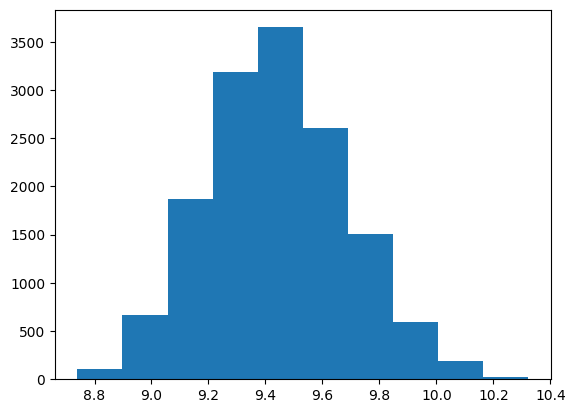

In [19]:
plt.hist(model_dist_xy(model, ideal, 2))
plt.show()

In [10]:
naive_acc_bound(model, group)

(1.0, 2.4458649158477783)

In [28]:
irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs)

[0, 1, 2, 3, 4] coef_sum tensor([6.8483, 6.8587, 6.7948, 6.8290, 6.8086, 6.8145, 6.8135, 6.8671, 6.7878,
        6.8544, 6.8364, 6.8867, 6.7939, 6.8766, 6.8363, 6.8558, 6.8340, 6.8829,
        6.8353, 6.8270, 6.8286, 6.7917, 6.8262, 6.8689, 6.8261])
[0, 1, 2, 3, 4] coef_mean tensor(6.8353)
1d-0
l diff tensor(1.8304e-05)
r diff tensor(1.3973e-05)
u diff tensor(0.0017)
4d-1
l diff tensor(2.6048e-05)
r diff tensor(2.6962e-05)
u diff tensor(0.0022)
total
l 1-r2 tensor(3.9443e-05)
r 1-r2 tensor(3.9808e-05)
u 1-r2 tensor(0.0022)
bias 1-r2 tensor(0.0165)


(1.0, 0.9154651165008545)

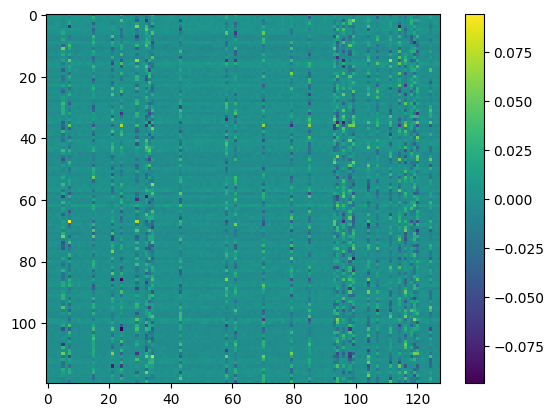

In [19]:
plt.imshow(un - un_ideal)
plt.colorbar()
plt.show()

In [51]:
((un - un_ideal).norm(dim=0) > 0.2).nonzero().flatten()

tensor([  5,   7,  15,  21,  24,  29,  32,  33,  34,  43,  58,  61,  70,  79,
         85,  93,  94,  96,  98,  99, 104, 111, 114, 116, 119, 120, 124])

In [44]:
ures_big = (un - un_ideal)[:, ((un - un_ideal).norm(dim=0) > 0.2).nonzero().flatten()]

In [47]:
t.svd(ures_big)[1]

tensor([0.4051, 0.3782, 0.3594, 0.3562, 0.3440, 0.3319, 0.3236, 0.2999, 0.2909,
        0.2836, 0.2738, 0.2672, 0.2515, 0.2417, 0.2181, 0.2094, 0.2019, 0.1956,
        0.1833, 0.1678, 0.1517, 0.1373, 0.1306, 0.1269, 0.1207, 0.1134, 0.0913])

In [42]:
7 in irrep_idx_dict['4d-1']

True

In [23]:
ubias = model.unembed_bias.detach().T

In [24]:
(proj @ ubias).norm()**2 / ubias.norm()**2

tensor(0.0165)

In [25]:
(proj @ ubias).max()

tensor(0.4138)

In [61]:
ubias.norm()

tensor(3.6078)

In [26]:
(proj @ (un - un_ideal)).norm()**2 / (un - un_ideal).norm()**2

tensor(0.9972)

(array([7200.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7200.]),
 array([4.79713058, 4.89955549, 5.0019804 , 5.10440531, 5.20683022,
        5.30925512, 5.41168003, 5.51410494, 5.61652985, 5.71895475,
        5.82137966]),
 <BarContainer object of 10 artists>)

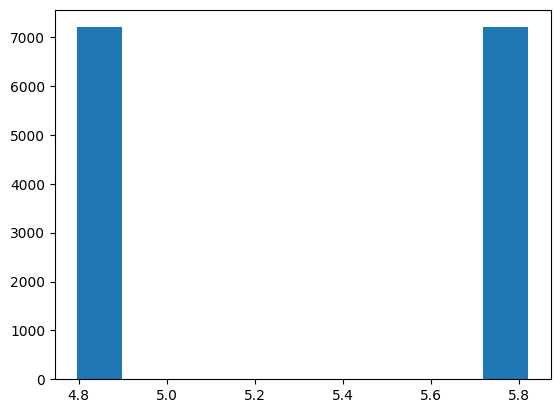

In [32]:
plt.hist(margins)

In [33]:
set(margins)

{4.797130584716797,
 4.797131538391113,
 4.79713249206543,
 4.797133445739746,
 4.7971343994140625,
 4.797135353088379,
 4.797136306762695,
 4.797137260437012,
 4.797138214111328,
 4.7971391677856445,
 4.797140121459961,
 4.797141075134277,
 4.797142028808594,
 4.79714298248291,
 4.797143936157227,
 4.797144889831543,
 5.821364402770996,
 5.8213653564453125,
 5.821366310119629,
 5.821367263793945,
 5.821368217468262,
 5.821369171142578,
 5.8213701248168945,
 5.821371078491211,
 5.821372032165527,
 5.821372985839844,
 5.82137393951416,
 5.821374893188477,
 5.821375846862793,
 5.821376800537109,
 5.821377754211426,
 5.821378707885742,
 5.821379661560059}

In [28]:
out.topk(k=2).values[0] - out.topk(k=2).values[1]

tensor(5.8214, grad_fn=<SubBackward0>)

In [158]:
loss = lambda x: -t.log(t.exp(x[0]) / t.exp(x).sum())

In [159]:
max_loss = 0
for _ in tqdm(range(1000000)):
    err = t.randn_like(out)#.sign() * 11
    err = err / err.norm() * 8.3
    max_loss = max(max_loss, loss(out + err).item())
loss(out).item(), max_loss

100%|██████████| 1000000/1000000 [00:20<00:00, 49350.99it/s]


(0.0010046042734757066, 0.0495346337556839)

In [31]:
model = model.fold_linear()
# ideal = ideal.fold_linear()
ln1, rn1, un1 = model.get_neurons()
ln2, rn2, un2 = ideal.get_neurons()
ln1, rn1, un1 = ln1[:,:, part_idxs], rn1[:,:, part_idxs], un1[:,:, part_idxs]
ln2, rn2, un2 = ln2[:,:, part_idxs], rn2[:,:, part_idxs], un2[:,:, part_idxs]
ln_noise = t.randn_like(ln1)
ln_noise = ln_noise / ln_noise.norm() * (ln1 - ln2).norm()
rn_noise = t.randn_like(rn1)
rn_noise = rn_noise / rn_noise.norm() * (rn1 - rn2).norm()
un_noise = t.randn_like(un1)
un_noise = un_noise / un_noise.norm() * (un1 - un2).norm()
ln3, rn3, un3 = ln2 + ln_noise, rn2 + rn_noise, un2 + un_noise

NameError: name 'part_idxs' is not defined

In [15]:
un1.norm(), un2.norm() 

(tensor(27.0105), tensor(26.9070))

In [20]:
noise_model = copy.deepcopy(model)
noise_model.embedding_left = nn.Parameter(ln3)
noise_model.embedding_right = nn.Parameter(rn3)
noise_model.unembedding = nn.Parameter(un3.mT)

In [21]:
test_loss(noise_model, data)

{'G0_loss': tensor([0.2678]),
 'G0_loss_std': tensor([0.1247]),
 'G0_acc': tensor([1.])}

In [57]:
test_loss(noise_model, data), test_loss(ideal, data),  test_loss(model, data)

({'G0_loss': tensor([0.1731]),
  'G0_loss_std': tensor([0.1883]),
  'G0_acc': tensor([0.9990])},
 {'G0_loss': tensor([0.1231]),
  'G0_loss_std': tensor([0.0968]),
  'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0296]),
  'G0_loss_std': tensor([0.0080]),
  'G0_acc': tensor([1.])})

In [29]:
model_dist2(model, ideal)#, irrep_idx_dict, vecs)

tensor(151.1256)

In [28]:
sorted(dist.tolist())

TypeError: 'float' object is not iterable

In [44]:
model_dist_parted(model, ideal, irrep_idx_dict, vecs)

1d-0
l diff tensor(0.1423)
r diff tensor(0.1301)
u diff tensor(0.1309)
l norm tensor(37.6832)
r norm tensor(37.6227)
u norm tensor(8.6710)
12.21975326538086
4d-1
l diff tensor(0.5003)
r diff tensor(0.4084)
u diff tensor(2.0580)
l norm tensor(37.3536)
r norm tensor(37.2156)
u norm tensor(6.8900)
159.40463256835938
4d-1
l diff tensor(0.)
r diff tensor(0.)
u diff tensor(1.4427)
l norm tensor(8.8416)
r norm tensor(8.7849)
u norm tensor(1.4427)
25.430316925048828


197.05470275878906

In [32]:
_, _, un1 = model.get_neurons(True)
_, _, un2 = ideal.get_neurons(True)

In [43]:
((un1 - un2).norm(dim=0))[part_idxs].max() #/ un1.norm(dim=0))[part_idxs]

tensor(0.5175)

In [61]:
(ideal.unembedding - model.unembedding)[0].norm(dim=1)

tensor([3.9519e-01, 1.9263e+00, 2.7491e-02, 0.0000e+00, 2.0834e-03, 2.9060e-02,
        3.0195e-01, 4.8089e-01, 1.3822e+00, 2.9299e-01, 5.6391e-04, 1.7642e+00,
        4.3101e-01, 2.3929e-01, 3.8706e-04, 1.8467e-01, 3.0984e-01, 6.9950e-03,
        1.4025e+00, 1.1464e-01, 0.0000e+00, 2.8585e-01, 1.7904e+00, 2.1838e-01,
        1.2053e-04, 4.7698e-01, 1.7771e+00, 4.6449e-02, 1.2915e-04, 1.2651e-01,
        4.9187e-03, 1.3275e-01, 1.5971e+00, 8.5666e-02, 4.7559e-01, 0.0000e+00,
        9.9433e-02, 3.8776e-01, 1.8291e+00, 8.8188e-01, 9.8395e-02, 1.2016e-04,
        0.0000e+00, 4.6339e-01, 3.0990e-02, 1.6035e-02, 4.7704e-01, 1.9921e-03,
        4.4426e-01, 3.2006e-01, 2.2652e-01, 1.8414e+00, 1.0796e+00, 1.7409e-02,
        8.8652e-02, 4.2277e-01, 1.8674e+00, 1.2950e-03, 4.2510e-01, 4.7889e-01,
        1.8257e+00, 8.6694e-02, 8.8028e-02, 4.6159e-01, 1.5211e+00, 1.6752e+00,
        1.5701e-02, 1.8629e+00, 4.4153e-01, 3.2458e-01, 1.3208e-03, 4.6803e-02,
        0.0000e+00, 1.5985e-03, 1.2449e+

In [43]:
ideal.unembedding[0, part_idxs[4], :15], model.unembedding[0, part_idxs[4], :15]

(tensor([-0.9858,  0.2464,  0.2464,  0.2464,  0.2464, -0.9858, -0.9858,  0.2464,
          0.2464,  0.2464,  0.2464, -0.9858,  0.2464,  0.2464,  0.2464],
        grad_fn=<SliceBackward0>),
 tensor([-0.9570,  0.1998,  0.2163,  0.2846,  0.2874, -1.0399, -1.0421,  0.2721,
          0.2724,  0.2598,  0.1809, -0.9766,  0.2939,  0.1614,  0.2129],
        grad_fn=<SliceBackward0>))

In [37]:
irrep_idx_dict['4d-1'].index(88)

65

In [38]:
b_labels[65], c_labels[65]

(tensor(5, dtype=torch.int32), tensor(5, dtype=torch.int32))

In [12]:
from coset_bounds import model_dist as cdist

In [15]:
cdist(model, ideal)

l diff tensor(0.5003)
r diff tensor(0.4084)
u diff tensor(2.0830)
l norm tensor(37.6832)
r norm tensor(37.6227)
u norm tensor(8.9174)


tensor(164.9650)

In [136]:
ideal.unembedding[0,5,:].norm(), model.unembedding[0,5,:].norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(0.1013, grad_fn=<LinalgVectorNormBackward0>))

In [148]:
(ideal.unembedding[0] - model.unembedding[0]).norm(dim=1).argmax()

tensor(88)

In [150]:
ideal.unembedding[0,88].norm(), model.unembedding[0,88].norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(1.2796, grad_fn=<LinalgVectorNormBackward0>))

In [154]:
test_loss(ideal, data), test_loss(model, data)

({'G0_loss': tensor([0.1231]),
  'G0_loss_std': tensor([0.0968]),
  'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0296]),
  'G0_loss_std': tensor([0.0080]),
  'G0_acc': tensor([1.])})

In [163]:
ideal(t.tensor([[10, 15]])).max()

tensor(15.5970, grad_fn=<MaxBackward1>)

In [173]:
irrep_model = copy.deepcopy(ideal)
irrep_name = '1d-0'
irrep_model.embedding_left.data = ideal.embedding_left[:,:,irrep_idx_dict[irrep_name]]
irrep_model.embedding_right.data = ideal.embedding_right[:,:,irrep_idx_dict[irrep_name]]
irrep_model.unembedding.data = ideal.unembedding[:,irrep_idx_dict[irrep_name]]

In [171]:
test_loss(irrep_model, data)

{'G0_loss': tensor([0.2198]),
 'G0_loss_std': tensor([4.2085e-07]),
 'G0_acc': tensor([1.])}

In [180]:
irrep_model(t.tensor([[11, 17]]))

tensor([[[-3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460,
          -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460,
          -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.84

In [183]:
irrep_model.unembedding[0,:,:10]

tensor([[-0.5594,  0.5594,  0.5594, -0.5594, -0.5594,  0.5594,  0.5594, -0.5594,
         -0.5594,  0.5594],
        [-0.5598,  0.5598,  0.5598, -0.5598, -0.5598,  0.5598,  0.5598, -0.5598,
         -0.5598,  0.5598],
        [-0.0010,  0.0010,  0.0010, -0.0010, -0.0010,  0.0010,  0.0010, -0.0010,
         -0.0010,  0.0010]], grad_fn=<SliceBackward0>)

In [48]:

irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
4d-0 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
6d-0 torch.Size([120, 36])
5d-1 torch.Size([120, 25])
4d-1 torch.Size([120, 16])
1d-1 torch.Size([120, 1])


In [54]:
# Proportion of variance explained by each irrep, for each neuron
ures_expl = dict()
ubias_expl = dict()

for name, basis in irrep_bases.items():
    ures_expl[name] = (basis.H @ ures_big).norm(dim=0)**2 / (ures_big.norm(dim=0)**2 + 1e-8)
    ubias_expl[name] = (basis.H @ ubias).norm(dim=0)**2 / (ubias.norm(dim=0)**2 + 1e-8)

In [56]:
ures_expl

{'1d-0': tensor([2.2703e-03, 2.3903e-06, 2.2074e-03, 3.8170e-03, 5.3694e-06, 4.7517e-04,
         1.3478e-05, 9.9386e-12, 9.7257e-03, 1.0623e-02, 2.3099e-05, 8.9464e-04,
         5.6647e-04, 1.6329e-03, 2.1714e-02, 7.0234e-04, 4.1935e-04, 1.1982e-04,
         5.5475e-05, 8.4600e-03, 1.2267e-03, 2.9535e-03, 5.9241e-09, 3.3240e-03,
         5.1312e-03, 1.4887e-05, 9.2031e-12]),
 '4d-0': tensor([0.1483, 0.1038, 0.0868, 0.1295, 0.0929, 0.0817, 0.1756, 0.1694, 0.1428,
         0.1229, 0.1398, 0.1425, 0.1346, 0.0456, 0.1851, 0.1676, 0.1807, 0.0891,
         0.0623, 0.1595, 0.1011, 0.1832, 0.1181, 0.1393, 0.0894, 0.1435, 0.1533]),
 '5d-0': tensor([0.2572, 0.2210, 0.1895, 0.3072, 0.2438, 0.2120, 0.1813, 0.2150, 0.1564,
         0.2704, 0.2162, 0.2885, 0.2417, 0.2044, 0.1561, 0.0952, 0.1882, 0.2290,
         0.2489, 0.1922, 0.2993, 0.1563, 0.3368, 0.2274, 0.2981, 0.2231, 0.1733]),
 '6d-0': tensor([0.3363, 0.2904, 0.3211, 0.2642, 0.3670, 0.3065, 0.2789, 0.3254, 0.3593,
         0.2445, 0.2884, 0

In [57]:
ubias_expl

{'1d-0': tensor([0.9835]),
 '4d-0': tensor([0.0027]),
 '5d-0': tensor([0.0015]),
 '6d-0': tensor([0.0055]),
 '5d-1': tensor([0.0019]),
 '4d-1': tensor([0.0012]),
 '1d-1': tensor([0.0038])}